<a href="https://colab.research.google.com/github/btnwilson/TSCSeizureClassification/blob/main/Seizure_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Seizure Classification of Mouse Model EEG Data

The primary objective of this notebook is to develop an effective seizure classification model using EEG data collected from a mouse model of tuberous sclerosis complex (TSC) at the University of Vermont. TSC is a genetic disorder that can result in neurological symptoms, including seizures, and this work aims to leverage machine learning techniques to detect seizure events accurately within EEG recordings.

To achieve this, multiple modeling approaches and data processing techniques were employed to optimize performance. This allowed for a systematic exploration of techniques to identify the most effective model for the task. The progression is as follows:

###Initial Baseline:
Simple CNN on Raw Time-Series Data: As a starting point, a Convolutional Neural Network (CNN) was trained directly on the raw EEG time-series data. CNNs were chosen for their ability to capture temporal and spatial patterns in the signal.

###Addressing Class Imbalance:
CNN with Weighted Loss Function: To tackle the issue of class imbalance, a weighted loss function was incorporated, assigning higher penalties for misclassifications of the minority class (seizures). This modification aimed to improve the model's sensitivity to seizure events.

###Advanced Data Processing and Model Architectures:
Data Downsampling, PCA, and SMOTE: The EEG data was downsampled to reduce computational load, followed by Principal Component Analysis (PCA) for dimensionality reduction to retain the most significant features. The Synthetic Minority Oversampling Technique (SMOTE) was applied to generate synthetic samples for the minority class, ensuring a more balanced dataset.

###LSTM Model:
With the preprocessed data, a Long Short-Term Memory (LSTM) model was implemented to leverage its ability to learn long-term temporal dependencies in sequential data.
###Transformer Model:
A transformer-based architecture was explored, utilizing self-attention mechanisms to capture relationships across the entire time-series signal.
###Final CNN Architecture:
A refined CNN was developed to combine the insights gained from earlier models, incorporating the preprocessed data and advanced tuning for optimal performance.

This iterative approach enabled a thorough exploration of different methodologies, providing valuable insights into the strengths and limitations of each model type. By progressively enhancing the preprocessing and modeling techniques, the final models aim to achieve robust seizure detection, contributing to improved understanding and monitoring of TSC-related seizures in this mouse model.

**Data is not publicly availible**

In [ ]:
#Import Required packages and mount drive for data access
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import os
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from google.colab import drive
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import joblib
from sklearn.decomposition import PCA
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Deep Learning Final Project")

Mounted at /content/drive


##Load data and define model wrapper functions

In [ ]:
#Load preprocessed data. Has already been normalized using MAD and bandpass filtered with cuttoffs of 0.5-50 Hz
all_raw_data = np.load("DeepLearningSeizureData.npz")
raw_data = all_raw_data["data"]
raw_labels = all_raw_data["labels"]


In [ ]:
#Inspect the data
print(f"Shape of data: {raw_data.shape}")
print(f"Shape of labels: {raw_labels.shape}")
print(f"Sample of data: {raw_data[0:5]}")
print(f"Sample of labels: {raw_labels[0:5]}")
print(f"Number of Seizures: {np.sum(raw_labels)}")
print(type(raw_data))

Shape of data: (53956, 3840)
Shape of labels: (53956,)
Sample of data: [[-0.8066991  -0.6384619  -0.41858765 ... -1.97067048 -1.07025842
  -1.82003927]
 [ 0.5941993   1.2486      0.32305682 ... -0.64834347 -1.59815713
  -1.42756616]
 [-2.36512452 -1.45402048 -1.01493487 ...  0.25994887  0.7408114
   1.48040768]
 [-0.57854143 -1.31760154 -0.79121838 ...  1.26488113  2.604289
   3.7575334 ]
 [ 0.12601576  0.31994299  1.30551391 ...  1.12120227  1.3433372
   1.50579157]]
Sample of labels: [0 0 0 0 0]
Number of Seizures: 417
<class 'numpy.ndarray'>


In [ ]:
#Create a simple stratified split
data_train, data_test, labels_train, labels_test = train_test_split(raw_data, raw_labels, test_size=0.25, shuffle=True, stratify=raw_labels)

In [ ]:
#check split and seizure counts
print(labels_train)
print(np.sum(labels_train))
print(labels_test)
print(np.sum(labels_test))

[0 0 0 ... 0 0 0]
313
[0 0 0 ... 0 0 0]
104


In [ ]:
#Define dataset class that can be used to pass data into data loader
class EEGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]
        return sample, label

In [ ]:
#Create instances of train and test data class
train_dataset = EEGDataset(data_train, labels_train)
test_dataset = EEGDataset(data_test, labels_test)

#Pass to data loader with batch size 32
batch_size = 32
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
#check type
train_dataset[0]

(tensor([-1.1303, -1.0285, -0.3497,  ...,  0.6717,  1.3754,  0.8888]),
 tensor(0))

In [ ]:
#Wrapper to run a specified model and produce training and validation curves
def run_model(model, train_loader, test_loader, num_epochs, loss_fn, optimizer, model_name):
  #Pass model to processor
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)
  loss_fn = loss_fn
  optimizer = optimizer
  # Initialize variables to track the best model and best losses
  best_train_loss = float('inf')
  best_val_loss = float('inf')
  best_model_path = f"{model_name}_best_model.pth"

  # Initialize lists to store loss values for plotting
  train_losses = []
  val_losses = []

  for epoch in range(num_epochs):
      # Initialize variables to track losses for the current epoch
      epoch_train_loss = 0.0
      epoch_val_loss = 0.0

      # Training phase
      model.train()
      for batch_idx, (data, labels) in enumerate(train_loader):
          # Move data to the GPU if available
          data, labels = data.to(device), labels.to(device)
          data = data.unsqueeze(1)

          # Forward pass
          outputs = model(data)
          loss = loss_fn(outputs.squeeze(), labels.float())

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # Accumulate training loss
          epoch_train_loss += loss.item()

      # Compute average training loss for this epoch
      epoch_train_loss /= len(train_loader)

      # Validation phase
      model.eval()
      with torch.no_grad():
          for data, labels in test_loader:
              # Move data to the GPU if available
              data, labels = data.to(device), labels.to(device)
              data = data.unsqueeze(1)
              #forward pass through model
              outputs = model(data)
              loss = loss_fn(outputs.squeeze(), labels.float())

              # Accumulate validation loss
              epoch_val_loss += loss.item()

      # Compute average validation loss for this epoch
      epoch_val_loss /= len(test_loader)

      # Store the losses for plotting
      train_losses.append(epoch_train_loss)
      val_losses.append(epoch_val_loss)

      # Print the best training and validation loss at the end of the epoch
      print(f"Epoch [{epoch+1}/{num_epochs}], "
            f"Train Loss: {epoch_train_loss:.4f}, "
            f"Validation Loss: {epoch_val_loss:.4f}")

      # Save the best model
      if epoch_train_loss < best_train_loss:
          best_train_loss = epoch_train_loss
      if epoch_val_loss < best_val_loss:
          best_val_loss = epoch_val_loss
          torch.save(model.state_dict(), best_model_path)
          print(f"Best model saved at epoch {epoch+1} with validation loss {epoch_val_loss:.4f}")

  # Plot the loss curves for training and validation
  plt.figure(figsize=(10, 6))
  plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", color='b', marker='o')
  plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", color='r', marker='x')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Training and Validation Loss Curves")
  plt.legend()
  plt.grid(True)
  plt.show()



In [ ]:
#Function to evaluate a model that was trained and create a confusion matrix and sample several examples of
# inputs that were properly and improperly classified
def evaluate_model(model, test_data_loader, model_name):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)
  best_model_path = f"{model_name}_best_model.pth"
  # Load the best model
  model.load_state_dict(torch.load(best_model_path))
  model.eval()  # Set the model to evaluation mode

  # Prepare lists for storing all predictions and labels
  all_preds = []
  all_labels = []
  all_test_samples = []

  # Get predictions and visualize some samples
  with torch.no_grad():
      for i, (data, labels) in enumerate(test_data_loader):
          data, labels = data.to(device), labels.to(device)
          all_test_samples.extend(data.cpu().numpy())
          data = data.unsqueeze(1)  # Adjust input shape for the model

          # Get model predictions
          outputs = model(data)
          outputs = torch.sigmoid(outputs)
          predicted_labels = torch.round(outputs.squeeze())

          # Store predictions and labels for the confusion matrix
          all_preds.extend(predicted_labels.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())


  # Convert to numpy arrays for easier manipulation
  all_preds = np.array(all_preds)
  all_labels = np.array(all_labels)
  all_test_samples = np.array(all_test_samples)

  cm = confusion_matrix(all_labels, all_preds)
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

  # Plot confusion matrix as percentages
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Non-Seizure', 'Seizure'], yticklabels=['Non-Seizure', 'Seizure'])
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix (Normalized to Percentage)')
  plt.show()

  # Get indices for the different cases
  correct_seizure_indices = np.where((all_preds == 1) & (all_labels == 1))[0]  # Predicted and true seizure
  correct_non_seizure_indices = np.where((all_preds == 0) & (all_labels == 0))[0]  # Predicted and true non-seizure
  incorrect_seizure_indices = np.where((all_preds == 0) & (all_labels == 1))[0]  # Predicted non-seizure, true seizure
  incorrect_non_seizure_indices = np.where((all_preds == 1) & (all_labels == 0))[0]  # Predicted seizure, true non-seizure

  time = np.arange(0,30, 1/128)
  # Plot 3 correct seizure predictions
  for i in range(3):
      idx = correct_seizure_indices[i]
      signal = all_test_samples[idx]
      true_label = all_labels[idx]
      pred_label = all_preds[idx]

      plt.figure(figsize=(10, 2))
      plt.plot(time, signal.flatten(), label='EEG Signal')
      plt.title(f"True Label: {true_label}, Predicted Label: {pred_label}")
      plt.xlabel('Time (s)')
      plt.ylabel('Amplitude')
      plt.legend()
      plt.show()

  # Plot 3 correct non-seizure predictions
  for i in range(3):
      idx = correct_non_seizure_indices[i]
      signal = all_test_samples[idx]
      true_label = all_labels[idx]
      pred_label = all_preds[idx]

      plt.figure(figsize=(10, 2))
      plt.plot(time, signal.flatten(), label='EEG Signal')
      plt.title(f"True Label: {true_label}, Predicted Label: {pred_label}")
      plt.xlabel('Time (s)')
      plt.ylabel('Amplitude')
      plt.legend()
      plt.show()

  # Plot 3 incorrect seizure predictions
  for i in range(3):
      idx = incorrect_seizure_indices[i]
      signal = all_test_samples[idx]
      true_label = all_labels[idx]
      pred_label = all_preds[idx]

      plt.figure(figsize=(10, 2))
      plt.plot(time, signal.flatten(), label='EEG Signal')
      plt.title(f"True Label: {true_label}, Predicted Label: {pred_label}")
      plt.xlabel('Time (s)')
      plt.ylabel('Amplitude')
      plt.legend()
      plt.show()

  # Plot 3 incorrect non-seizure predictions
  for i in range(3):
      idx = incorrect_non_seizure_indices[i]
      signal = all_test_samples[idx]
      true_label = all_labels[idx]
      pred_label = all_preds[idx]

      plt.figure(figsize=(10, 2))
      plt.plot(time, signal.flatten(), label='EEG Signal')
      plt.title(f"True Label: {true_label}, Predicted Label: {pred_label}")
      plt.xlabel('Time (s)')
      plt.ylabel('Amplitude')
      plt.legend()
      plt.show()

##Simple 4 convolutional block CNN training on time series data

In [ ]:
#Define the class of the first simple CNN used on the original raw data
class EEGCNN1D(nn.Module):
    #Constructor
    def __init__(self):
        super(EEGCNN1D, self).__init__()

        # 1st Convolutional Block
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        # 2nd Convolutional Block
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        # 3rd Convolutional Block
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * (3840 // 16), 128)  # Adjust based on sequence_length
        self.relu_fc1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)

    #Forward Pass Method
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu_fc1(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Epoch [1/10], Train Loss: 0.0436, Validation Loss: 0.0325
Best model saved at epoch 1 with validation loss 0.0325
Epoch [2/10], Train Loss: 0.0320, Validation Loss: 0.0227
Best model saved at epoch 2 with validation loss 0.0227
Epoch [3/10], Train Loss: 0.0279, Validation Loss: 0.0255
Epoch [4/10], Train Loss: 0.0261, Validation Loss: 0.0228
Epoch [5/10], Train Loss: 0.0235, Validation Loss: 0.0226
Best model saved at epoch 5 with validation loss 0.0226
Epoch [6/10], Train Loss: 0.0212, Validation Loss: 0.0215
Best model saved at epoch 6 with validation loss 0.0215
Epoch [7/10], Train Loss: 0.0178, Validation Loss: 0.0233
Epoch [8/10], Train Loss: 0.0151, Validation Loss: 0.0260
Epoch [9/10], Train Loss: 0.0152, Validation Loss: 0.0338
Epoch [10/10], Train Loss: 0.0105, Validation Loss: 0.0364


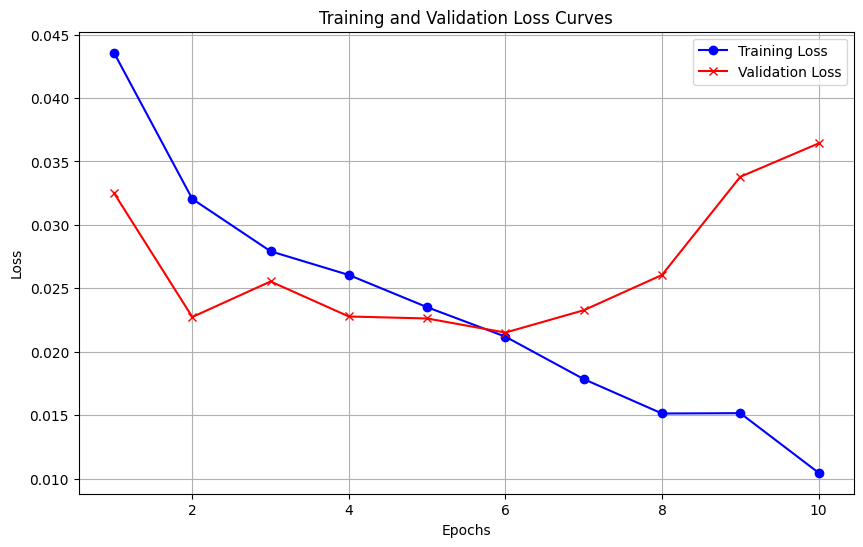

In [ ]:
#Load model to GPU and define loss function, optimizer and number of epochs
torch.cuda.empty_cache()
model = EEGCNN1D()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

#Run the model and produce loss curve
run_model(model, train_data_loader, test_data_loader, num_epochs, loss_fn, optimizer, "CNN1")

<ipython-input-18-82bd0fa13e8d>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


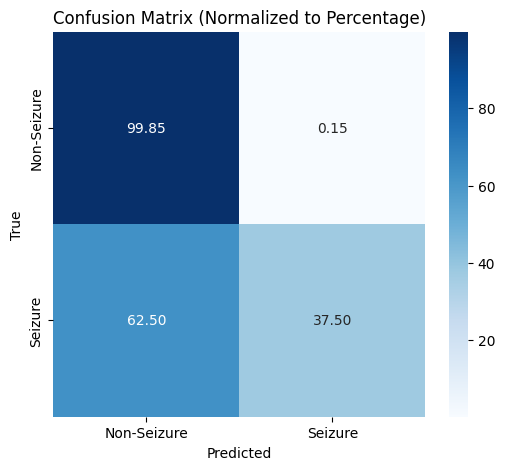

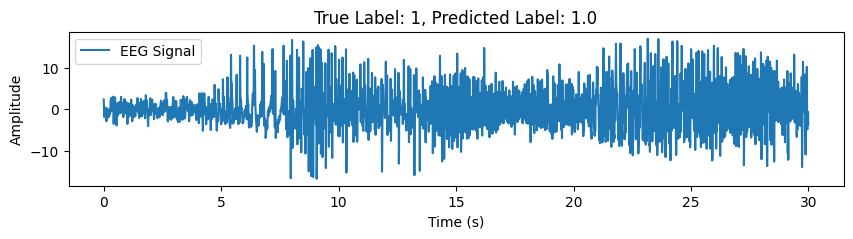

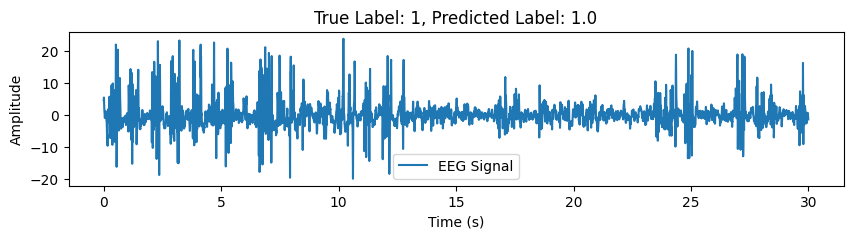

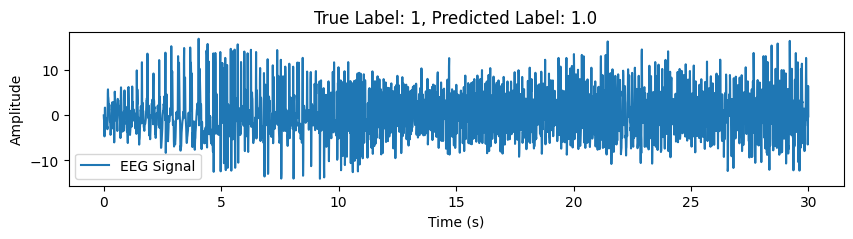

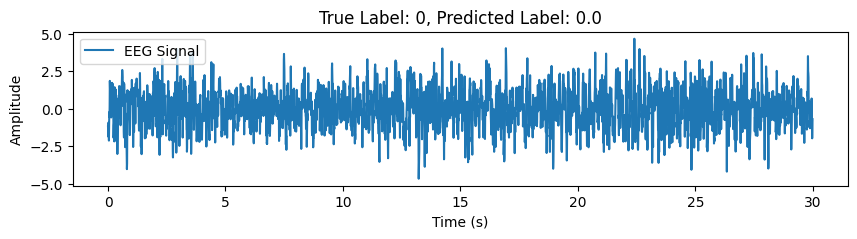

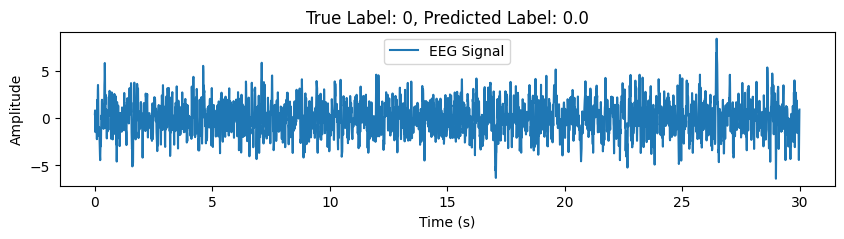

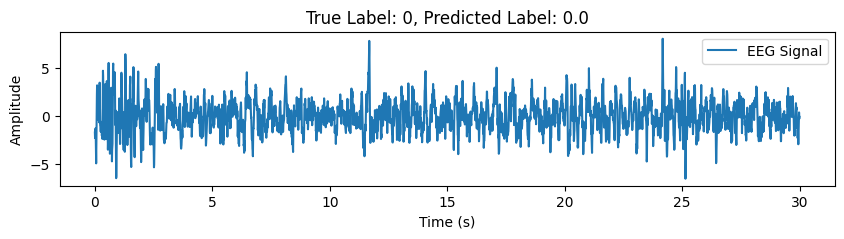

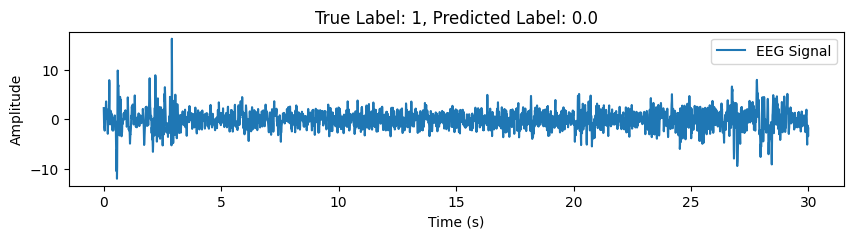

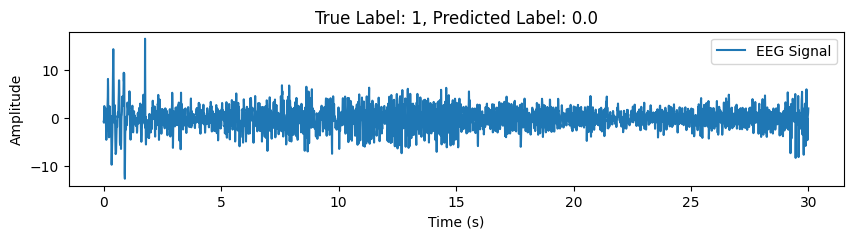

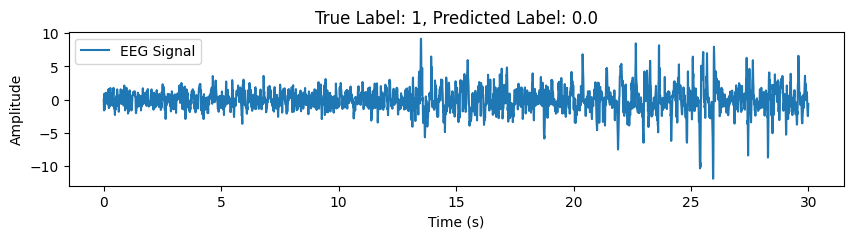

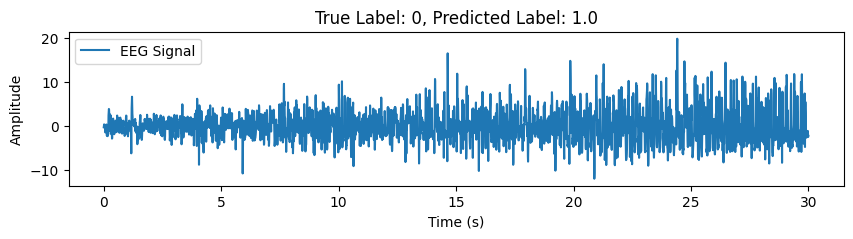

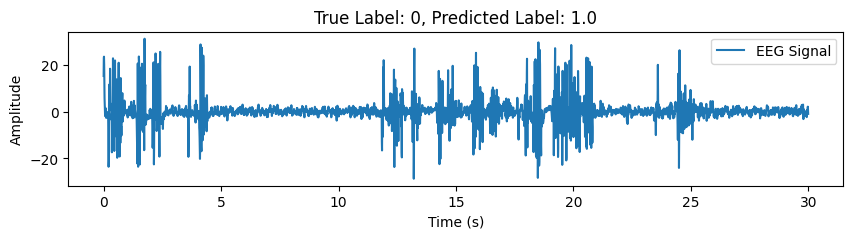

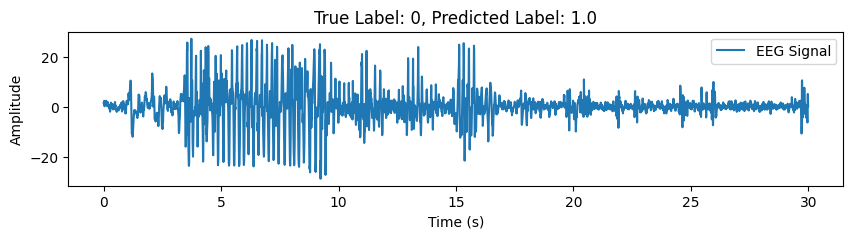

In [ ]:
# Clear GPU and the evaluate model and generate CM and sample outputs
torch.cuda.empty_cache()
evaluate_model(model, test_data_loader, "CNN1")

##Same CNN architecture also trained on time series data but using a weighted loss function to attempt and address the class imbalance

Epoch [1/10], Train Loss: 0.4034, Validation Loss: 0.2106
Best model saved at epoch 1 with validation loss 0.2106
Epoch [2/10], Train Loss: 0.2572, Validation Loss: 0.1988
Best model saved at epoch 2 with validation loss 0.1988
Epoch [3/10], Train Loss: 0.2287, Validation Loss: 0.1754
Best model saved at epoch 3 with validation loss 0.1754
Epoch [4/10], Train Loss: 0.2216, Validation Loss: 0.1662
Best model saved at epoch 4 with validation loss 0.1662
Epoch [5/10], Train Loss: 0.2070, Validation Loss: 0.1533
Best model saved at epoch 5 with validation loss 0.1533
Epoch [6/10], Train Loss: 0.6303, Validation Loss: 0.2160
Epoch [7/10], Train Loss: 0.2144, Validation Loss: 0.1726
Epoch [8/10], Train Loss: 0.2020, Validation Loss: 0.1755
Epoch [9/10], Train Loss: 0.1782, Validation Loss: 0.1789
Epoch [10/10], Train Loss: 0.1705, Validation Loss: 0.1554


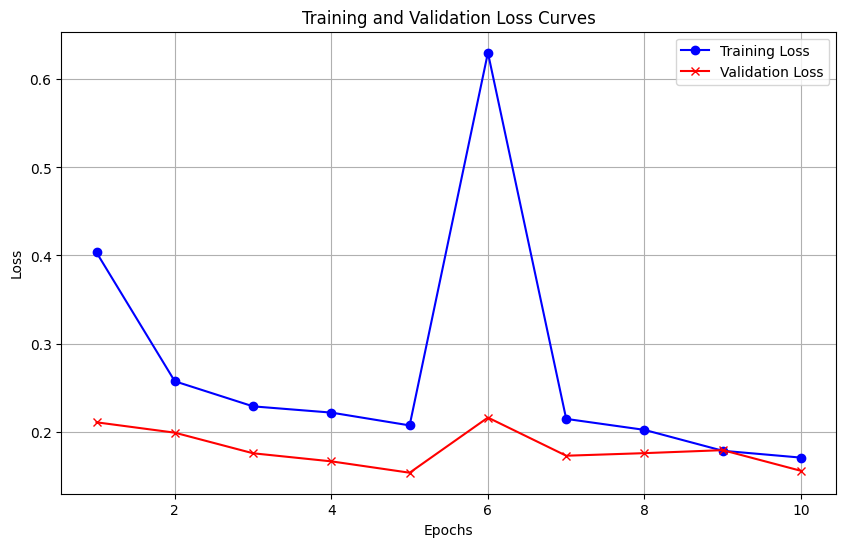

In [ ]:
#Implementation of the same network
torch.cuda.empty_cache()
model = EEGCNN1D()
weights = torch.tensor([1.0, 20.0])  # Increase the weight for seizure class
loss_fn = nn.BCEWithLogitsLoss(pos_weight=weights[1]) #Weighted loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
#Run model
run_model(model, train_data_loader, test_data_loader, num_epochs, loss_fn, optimizer, "CNN1Weighted")

<ipython-input-18-82bd0fa13e8d>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


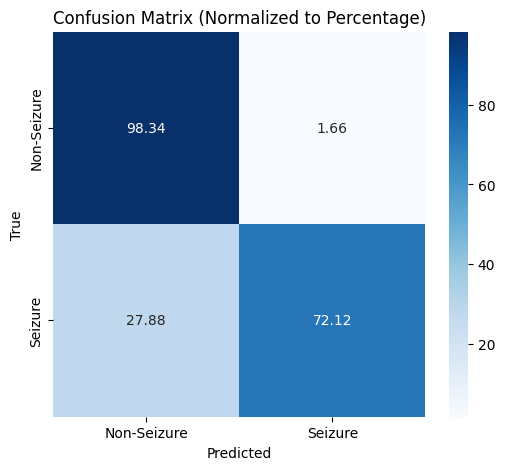

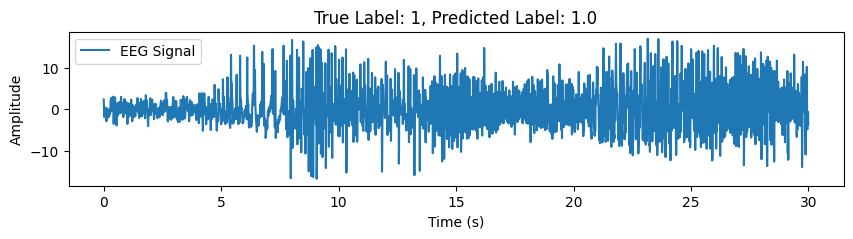

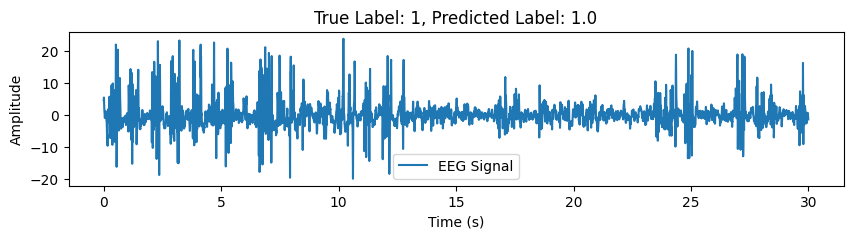

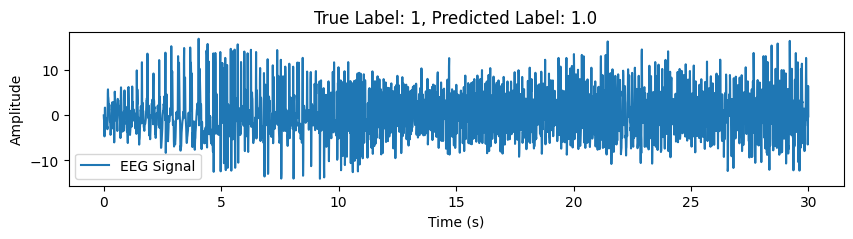

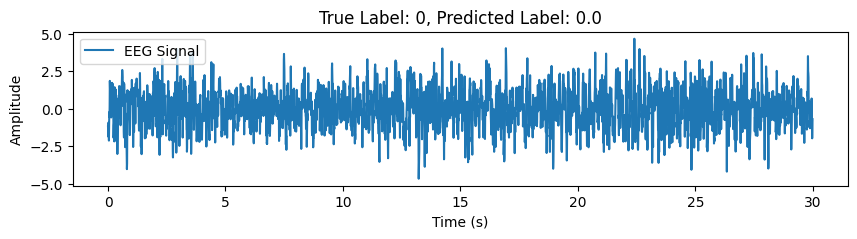

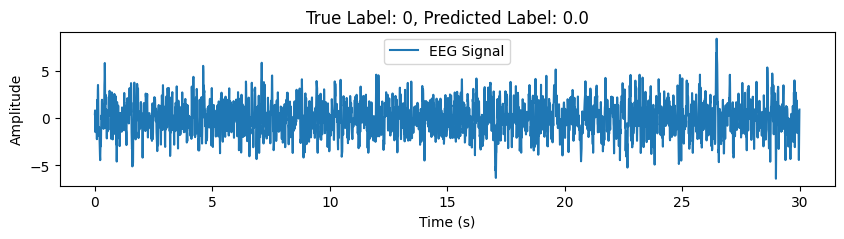

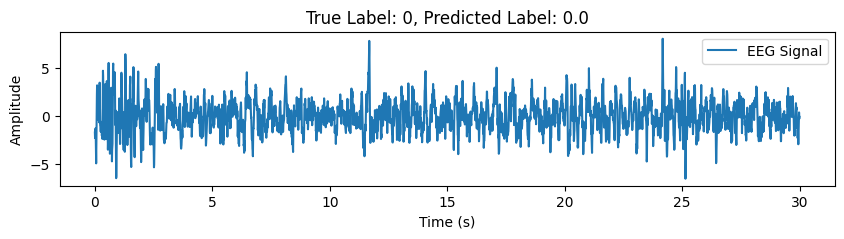

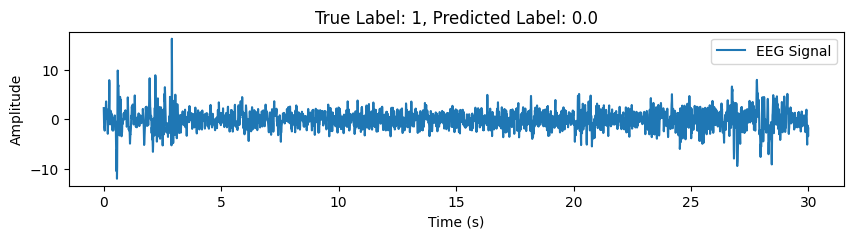

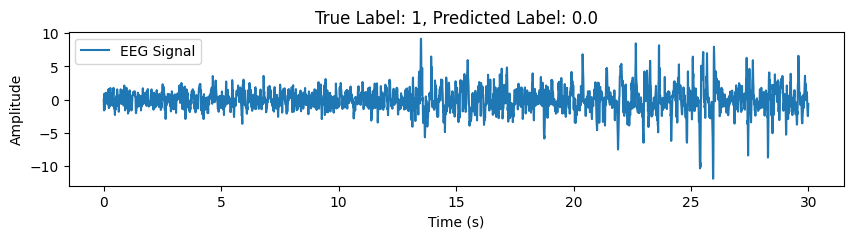

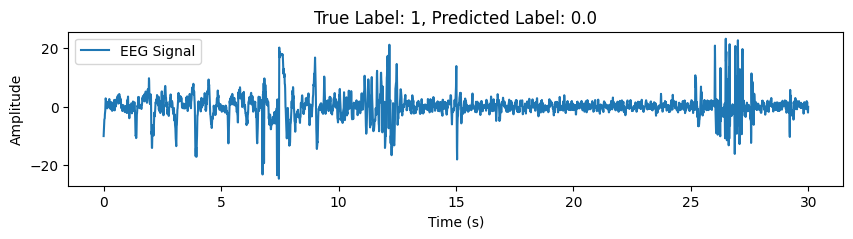

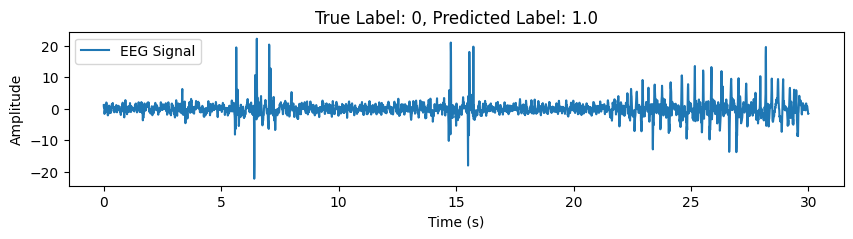

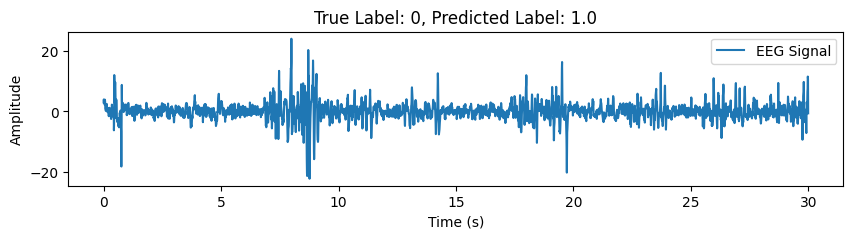

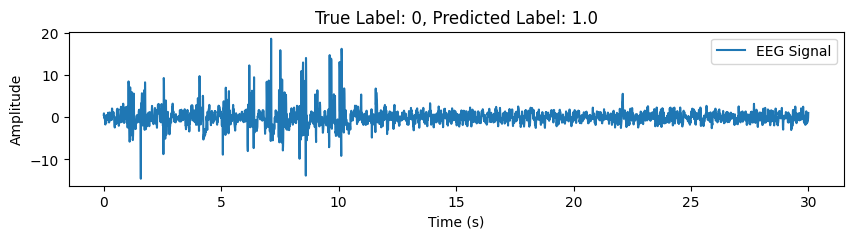

In [ ]:
#Clear GPU and then evaluate best model generating CM and sample outputs
torch.cuda.empty_cache()
evaluate_model(model, test_data_loader, "CNN1Weighted")

##Manipulate and transform data

Attempted to implement more complicated architectures on time series data but had consistent issues with overfitting. Solution was to transform and resample data.

In [ ]:
type(raw_data)

numpy.ndarray

In [ ]:
# Downsample the number of non seizure windows significantly previously was around 50,000
res = RandomUnderSampler(sampling_strategy=.1)
data_resampled, labels_resampled = res.fit_resample(raw_data, raw_labels)
print(f"Shape of data: {data_resampled.shape}")
print(f"Shape of labels: {labels_resampled.shape}")
print(f"Number of Seizures: {np.sum(labels_resampled)}")

Shape of data: (4587, 3840)
Shape of labels: (4587,)
Number of Seizures: 417


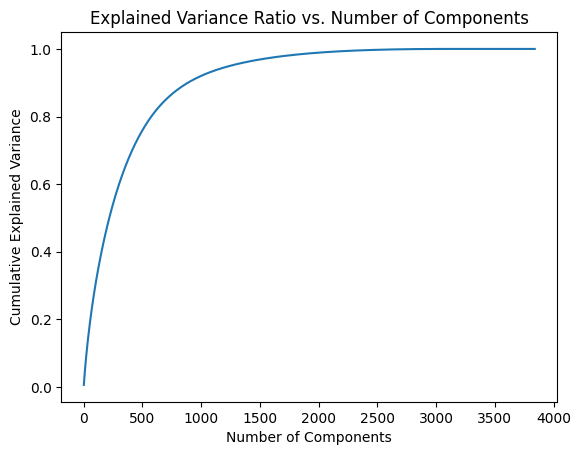

In [ ]:
#Perform PCA on downsampled data
pca = PCA()
X_pca = pca.fit_transform(data_resampled)

# Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance ratio to see how many principal components should be preserved
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid()
plt.show()

In [ ]:
#Decided on 1024 as that appears to be around the 90% mark for explained variance while reducing the dimension by a factor of 3
pca = PCA(n_components=1024)
pca_data_resampled = pca.fit_transform(data_resampled)
#Save the PCA so future inputs can be transformed
joblib.dump(pca, 'pca_model.pkl')
#check the shape
print(f"Shape of data: {pca_data_resampled.shape}")

Shape of data: (4587, 1024)


In [ ]:
#Apply SMOTE (Synthetic Minority Oversampling Technique) to increase the seizure class size
smote = SMOTE(sampling_strategy= .5)
data_smote, labels_smote = smote.fit_resample(pca_data_resampled, labels_resampled)
print(f"Shape of data: {data_smote.shape}")
print(f"Shape of labels: {labels_smote.shape}")
print(f"Number of Seizures: {np.sum(labels_smote)}")
print(np.unique(labels_smote))

Shape of data: (6255, 1024)
Shape of labels: (6255,)
Number of Seizures: 2085
[0 1]


In [ ]:
#Create a new train test split using the modified data
modified_data_train, modified_data_test, modified_labels_train, modified_labels_test = train_test_split(data_smote, labels_smote, test_size=0.25, shuffle=True, stratify=labels_smote)

In [ ]:
#Create instances of data class for modified data
modified_train_dataset = EEGDataset(modified_data_train, modified_labels_train)
modified_test_dataset = EEGDataset(modified_data_test, modified_labels_test)

#Transfer to a pytorch data loader object
batch_size = 32
modified_train_data_loader = DataLoader(modified_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
modified_test_data_loader = DataLoader(modified_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
#checj the number of elements in each data loader
print(len(modified_train_data_loader) * batch_size)
print(len(modified_test_data_loader) * batch_size)

4704
1568


##Implement and test and LSTM trained on transformed data

In [ ]:
#Define structure of a LSTM model
class EEGLSTM(nn.Module):
    #Constructor
    def __init__(self):
        super(EEGLSTM, self).__init__()
        self.hidden_size = 64
        self.num_layers = 1
        self.dropout = nn.Dropout(p=0.3)
        self.lstm = nn.LSTM(1024, self.hidden_size, self.num_layers, batch_first=True)

        # Fully connected output
        self.fc = nn.Linear(self.hidden_size, 1)


    #Forward pass method
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])  # Apply dropout to the LSTM output
        out = self.fc(out)
        return out


Epoch [1/20], Train Loss: 0.7013, Validation Loss: 0.6850
Best model saved at epoch 1 with validation loss 0.6850
Epoch [2/20], Train Loss: 0.6650, Validation Loss: 0.6670
Best model saved at epoch 2 with validation loss 0.6670
Epoch [3/20], Train Loss: 0.6335, Validation Loss: 0.6488
Best model saved at epoch 3 with validation loss 0.6488
Epoch [4/20], Train Loss: 0.6007, Validation Loss: 0.6302
Best model saved at epoch 4 with validation loss 0.6302
Epoch [5/20], Train Loss: 0.5650, Validation Loss: 0.6104
Best model saved at epoch 5 with validation loss 0.6104
Epoch [6/20], Train Loss: 0.5276, Validation Loss: 0.5895
Best model saved at epoch 6 with validation loss 0.5895
Epoch [7/20], Train Loss: 0.4879, Validation Loss: 0.5682
Best model saved at epoch 7 with validation loss 0.5682
Epoch [8/20], Train Loss: 0.4491, Validation Loss: 0.5465
Best model saved at epoch 8 with validation loss 0.5465
Epoch [9/20], Train Loss: 0.4103, Validation Loss: 0.5252
Best model saved at epoch 9 wi

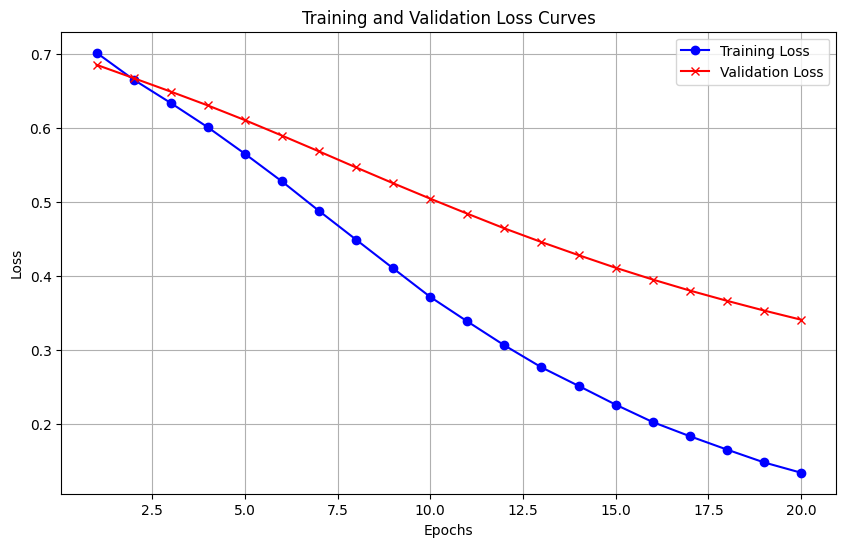

In [ ]:
#Clear GPU and load the model, define loss function and optimizer
torch.cuda.empty_cache()
model = EEGLSTM()
weights = torch.tensor([1.0, 1.0])  #Tried different values but ultimately achieved best performance at balanced weight
loss_fn = nn.BCEWithLogitsLoss(pos_weight=weights[1])
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 20
#run model and generate loss curves
run_model(model, modified_train_data_loader, modified_test_data_loader, num_epochs, loss_fn, optimizer, "LSTMWeighted")

In [ ]:
#Create new function to generate confusion matrices without sampling outputs because the PCA space is less interpretable
def evaluate_model_CM_only(model, test_loader, model_name):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)
  best_model_path = f"{model_name}_best_model.pth"
  # Load the best model
  model.load_state_dict(torch.load(best_model_path))
  model.eval()  # Set the model to evaluation mode

  # Prepare lists for storing all predictions and labels
  all_preds = []
  all_labels = []
  all_test_samples = []

  # Get predictions and visualize some samples
  with torch.no_grad():
      for i, (data, labels) in enumerate(test_loader):
          data, labels = data.to(device), labels.to(device)
          all_test_samples.extend(data.cpu().numpy())
          data = data.unsqueeze(1)  # Adjust input shape for the model

          # Get model predictions
          outputs = model(data)
          outputs = torch.sigmoid(outputs)
          predicted_labels = torch.round(outputs.squeeze())

          # Store predictions and labels for the confusion matrix
          all_preds.extend(predicted_labels.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())


  # Convert to numpy arrays for easier manipulation
  all_preds = np.array(all_preds)
  all_labels = np.array(all_labels)
  all_test_samples = np.array(all_test_samples)

  cm = confusion_matrix(all_labels, all_preds)
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

  # Plot confusion matrix as percentages
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Non-Seizure', 'Seizure'], yticklabels=['Non-Seizure', 'Seizure'])
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix (Normalized to Percentage)')
  plt.show()

<ipython-input-22-b88eba141655>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


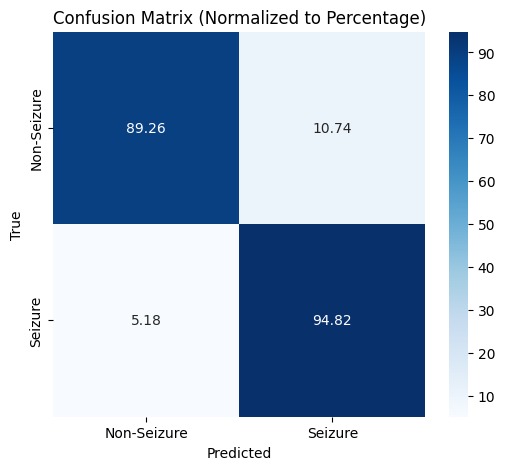

In [ ]:
#Evaluate and generate CM
torch.cuda.empty_cache()
evaluate_model_CM_only(model, modified_test_data_loader, "LSTMWeighted")

##Try a transformer based model on the transformed data

In [ ]:
#Define simple transformer architecture
class EEGTRANSFORMER(nn.Module):
    def __init__(self):
        super(EEGTRANSFORMER, self).__init__()
        dim_model = 1024
        num_heads = 4
        encoder_layer = nn.TransformerEncoderLayer(dim_model, num_heads, dim_feedforward=4*dim_model, activation = "relu", dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2, norm=nn.LayerNorm(dim_model))
        self.fc = nn.Linear(dim_model, 1)

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = torch.mean(x, dim=1)
        x = self.fc(x)
        return x

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/20], Train Loss: 1.1189, Validation Loss: 1.0293
Best model saved at epoch 1 with validation loss 1.0293
Epoch [2/20], Train Loss: 0.8532, Validation Loss: 0.8134
Best model saved at epoch 2 with validation loss 0.8134
Epoch [3/20], Train Loss: 0.6740, Validation Loss: 0.6731
Best model saved at epoch 3 with validation loss 0.6731
Epoch [4/20], Train Loss: 0.5494, Validation Loss: 0.6483
Best model saved at epoch 4 with validation loss 0.6483
Epoch [5/20], Train Loss: 0.4564, Validation Loss: 0.7246
Epoch [6/20], Train Loss: 0.3982, Validation Loss: 0.6624
Epoch [7/20], Train Loss: 0.3428, Validation Loss: 0.6904
Epoch [8/20], Train Loss: 0.2940, Validation Loss: 0.6284
Best model saved at epoch 8 with validation loss 0.6284
Epoch [9/20], Train Loss: 0.2499, Validation Loss: 0.5738
Best model saved at epoch 9 with validation loss 0.5738
Epoch [10/20], Train Loss: 0.2200, Validation Loss: 0.4879
Best model saved at epoch 10 with validation loss 0.4879
Epoch [11/20], Train Loss:

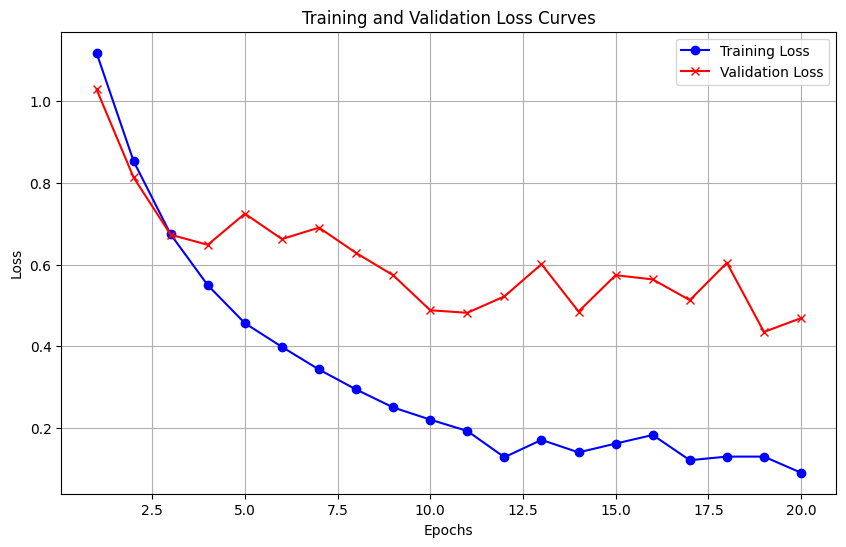

In [ ]:
#Clear GPU, upload new model
torch.cuda.empty_cache()
model = EEGTRANSFORMER()

#Define weighted loss function and optimizer
weights = torch.tensor([1.0, 4.0])  # Increase the weight for seizure class
loss_fn = nn.BCEWithLogitsLoss(pos_weight=weights[1])
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 20
#run model and generate loss curves
run_model(model, modified_train_data_loader, modified_test_data_loader, num_epochs, loss_fn, optimizer, "TransformerWeighted")

<ipython-input-22-b88eba141655>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


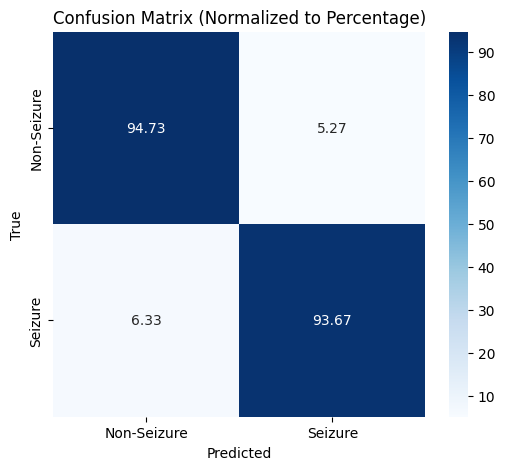

In [ ]:
#Clear GPU and load best version of transformer model to generate a CM
torch.cuda.empty_cache()
evaluate_model_CM_only(model, modified_test_data_loader, "TransformerWeighted")

##Go back and compare best model so far to a CNN trained on the transformed data

In [ ]:
#Define simple CNN similar to the one used on the time series data but with 1 less convolutional layer
class EEGCNNPCA1D(nn.Module):
    def __init__(self):
        super(EEGCNNPCA1D, self).__init__()

        # 1st Convolutional Block
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        # 2nd Convolutional Block
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        # 3rd Convolutional Block
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * (1024 // 8), 128)  # Adjust based on sequence_length
        self.relu_fc1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)


    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu_fc1(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Epoch [1/10], Train Loss: 0.8620, Validation Loss: 0.7967
Best model saved at epoch 1 with validation loss 0.7967
Epoch [2/10], Train Loss: 0.6493, Validation Loss: 0.5647
Best model saved at epoch 2 with validation loss 0.5647
Epoch [3/10], Train Loss: 0.4036, Validation Loss: 0.4526
Best model saved at epoch 3 with validation loss 0.4526
Epoch [4/10], Train Loss: 0.2473, Validation Loss: 0.3146
Best model saved at epoch 4 with validation loss 0.3146
Epoch [5/10], Train Loss: 0.1516, Validation Loss: 0.3936
Epoch [6/10], Train Loss: 0.1057, Validation Loss: 0.3482
Epoch [7/10], Train Loss: 0.0707, Validation Loss: 0.3185
Epoch [8/10], Train Loss: 0.0435, Validation Loss: 0.2983
Best model saved at epoch 8 with validation loss 0.2983
Epoch [9/10], Train Loss: 0.0302, Validation Loss: 0.3346
Epoch [10/10], Train Loss: 0.0279, Validation Loss: 0.3314


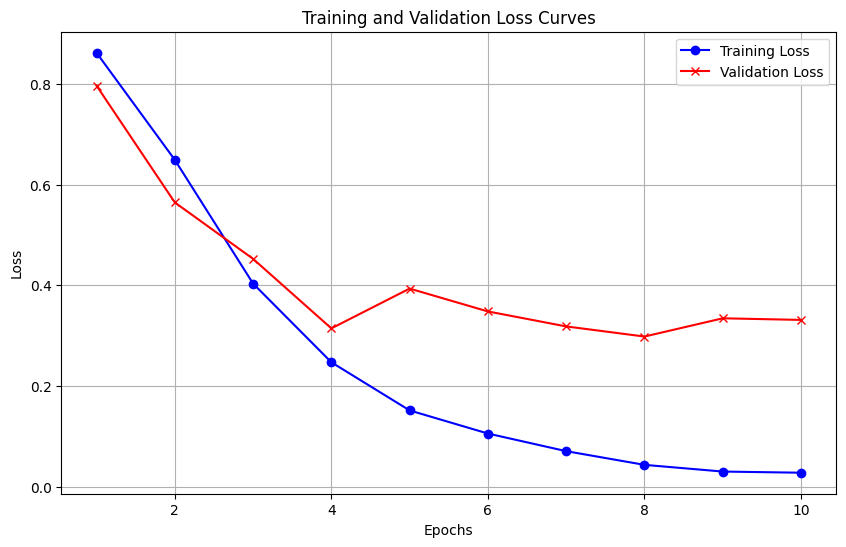

In [ ]:
#Clear GPU, upload new model
torch.cuda.empty_cache()
model = EEGCNNPCA1D()

#define weighted loss function and optimizer
weights = torch.tensor([1.0, 2.0])  # Increase the weight for seizure class
loss_fn = nn.BCEWithLogitsLoss(pos_weight=weights[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
#run model and generate loss curves
run_model(model, modified_train_data_loader, modified_test_data_loader, num_epochs, loss_fn, optimizer, "CNN1ModifiedData")

<ipython-input-22-b88eba141655>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


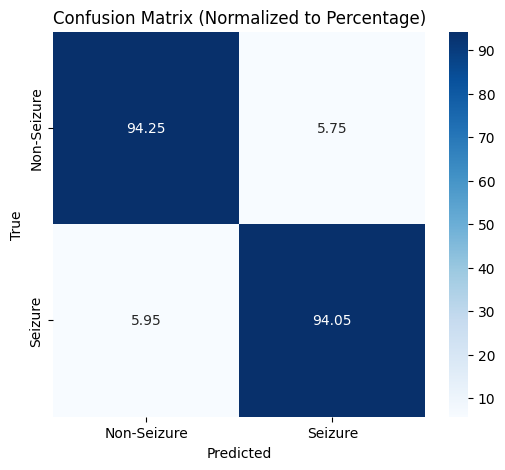

In [ ]:
#Load best weights and evaluate model generating a CM
torch.cuda.empty_cache()
evaluate_model_CM_only(model, modified_test_data_loader, "CNN1ModifiedData")

Ultimately, the transformer and CNN trained on the transformed data performed best in terms of test classification accuracy. Interestingly the CNN converged to higher accuracy faster than the transformer and is less complex. See second notebook for saliency plots generated for each model.